In [48]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sat May  8 06:49:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    42W / 300W |   1569MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# For Memory

In [49]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [50]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
import numpy as np
import pandas as pd 
import re
from tqdm import tqdm
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
data = pd.read_csv('/content/gdrive/MyDrive/Git hub Projects/3) Text Summarization /Reviews.csv', nrows=120000)

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      120000 non-null  int64 
 1   ProductId               120000 non-null  object
 2   UserId                  120000 non-null  object
 3   ProfileName             119995 non-null  object
 4   HelpfulnessNumerator    120000 non-null  int64 
 5   HelpfulnessDenominator  120000 non-null  int64 
 6   Score                   120000 non-null  int64 
 7   Time                    120000 non-null  int64 
 8   Summary                 119995 non-null  object
 9   Text                    120000 non-null  object
dtypes: int64(5), object(5)
memory usage: 9.2+ MB


In [58]:
data.drop_duplicates(subset=['Text'], inplace= True)
data.dropna(axis=0, inplace=True)

# Text Pre-Processing
Here we will be perfoming basic data pre-processingand data cleaning which will be aking the data ready for model.

In [59]:
# contraction mapping 
# the list will be containing all the contractions which will be used for expansions
contraction_mapping = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [60]:
data['Text'][:1]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
Name: Text, dtype: object

In [61]:
stop_words_removal = set(stopwords.words('english'))

def clean_text(text,num):
    text= text.lower()
    text= BeautifulSoup(text, 'lxml').text
    text= re.sub(r'\([^)]*\)', '', text)
    text= re.sub('"','',text)
    text= ' '.join([contraction_mapping[m] if m in contraction_mapping else m for m in text.split(' ')])
    text= re.sub(r"'s\b","",text)
    text= re.sub("[^a-zA-Z]", " ",text)
    text= re.sub('[m]{2,}', 'mm', text)
    if (num==0):
        words= [w for w in text.split() if not w in stop_words_removal]
    else:
        words=text.split()
        long_words=[]
        for i in words:
            if len (i)>1:
                long_words.append(i)
                                
return (" ".join(long_words)).strip()

In [62]:
#call the function for text 
cleaned_text= []
for j in tqdm(data['Text'].values):
    ex= clean_text(j,0)
    cleaned_text.append(ex)



100%|██████████| 104162/104162 [00:29<00:00, 3554.12it/s]


In [63]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [64]:
#call function for summary 
cleaned_summary=[]
for s in tqdm(data['Summary'].values):
    ex= clean_text(s,1)
    cleaned_summary.append(ex)

100%|██████████| 104162/104162 [00:19<00:00, 5295.86it/s]


In [65]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [66]:
data['clean_text']=cleaned_text
data['clean_summary']=cleaned_summary

In [67]:
data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,clean_text,clean_summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food


In [68]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'clean_text', 'clean_summary'],
      dtype='object')

In [69]:
data.replace('',np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

In [70]:
data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,clean_text,clean_summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food


# Understanding the Text Distribution Of Sequence

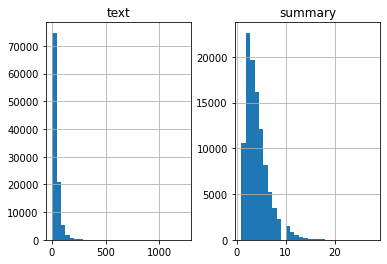

In [71]:
import matplotlib.pyplot as plt

cleaned_text_count= []
cleaned_summary_count=[]

for i in data['clean_text']:
    cleaned_text_count.append(len(i.split()))

for i in data['clean_summary']:
    cleaned_summary_count.append(len(i.split()))

df= pd.DataFrame({'text':cleaned_text_count, 'summary':cleaned_summary_count})

df.hist(bins=30)
plt.show()

This plot tells us about the maximum length distribution for summary and text.

Here we can conclude that the maximum length distribution for summary lies between 0 to 9. i.e most of the max length are between the scale of 0 to 9 

The similar way when we see the distribution for the text the max length lies between 0-30.This is a approx we are considering here.

In [72]:
count_summary=0
for i in data['clean_summary']:
    if(len(i.split())<=9):
        count_summary= count_summary+1
        
print(count_summary/len(data['clean_summary']))

0.9627957030574399


In [73]:
count_txt=0
for i in data['clean_text']:
    if(len(i.split())<=30):
        count_txt= count_txt+1
        
print(count_txt/len(data['clean_text']))

0.5535388281415147


In [74]:
#fixing the maximum length to 
#max text length = 60
#max summary length = 9
max_text_length= 30
max_summary_length= 9

In [75]:
cleaned_text= np.array(data['clean_text'])
cleaned_summary= np.array(data['clean_summary'])

short_text= []
short_summary= []

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_length and len(cleaned_text[i].split())<=max_text_length):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df = pd.DataFrame({'text':short_text, 'summary':short_summary})

In [76]:
df.head(5)

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,great just as good as the expensive brands


In [77]:
df['summary']= df['summary'].apply(lambda x: 'ssstok '+ x + ' eeetok')

In [78]:
df.head(5)

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,ssstok good quality dog food eeetok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,ssstok not as advertised eeetok
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,ssstok cough medicine eeetok
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,ssstok great taffy eeetok
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,ssstok great just as good as the expensive brands eeetok


Splitting Of the Dataset into Train and Test

In [79]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(np.array(df['text']), np.array(df['summary']), test_size=0.2, random_state=0, shuffle=True)

In [80]:
print('training size', x_train.shape,y_train.shape)

training size (45284,) (45284,)


In [81]:
print('test size',x_test.shape, y_test.shape)

test size (11321,) (11321,)


# Tokenization
Tokenization is important as it builds a vocabulary and converts it into sequence of integers

# Text Tokenizer

In [82]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#preparing a tokenizer for review data
x_token= Tokenizer()
x_token.fit_on_texts((x_train))


# Finding rare words and its frequency.

This can be found by considering the occurence frequence

In [83]:
threshold=4

count=0 # rare word count 
total_count=0 #gives the size of the vocabulary 
freq=0 # count of rare word frequency
total_freq=0 #frequency of the word in the vocabulary


for key,value in x_token.word_counts.items():
    total_count= total_count+1
    total_freq= total_freq+value
    if (value<threshold):
        count= count+1
        freq=freq+value

print("the percent of rare words are", (count/total_count)*100, "%")
print("the total coverage of rare words are", (freq/total_freq)*100, "%")

the percent of rare words are 66.30081929200804 %
the total coverage of rare words are 2.8671835981787095 %


In [84]:
x_train

array(['ordered pb plain chocolate peanut butter variety vastly pleased mixed according directions eaten crackers mixed raisins sunflower seeds favorite use however refrigerator porridge recipe enjoy',
       'totally agree swiss miss suggestion maybe write swiss miss come upwith cup',
       'notion cut tiny calorie servings bit silly brownies wonderful fat free heaven willing mail order beauties nonfat treat try hot frozen cool whip top send diet taste overdrive',
       ...,
       'oil amazing really wakes salad great along side high quality balsamic dip bread',
       'looking real punch gut coffee one get however want nice cup coffee weak strong one good bet',
       'strong pure need little bit get great flavor helps digestion smell strong'],
      dtype=object)

In [85]:
x_token= Tokenizer(num_words= total_count-count) #tokenizer is applied to the top most common words 
x_token.fit_on_texts(list(x_train))

#converting text sequence to integer sequence 
x_train_sq= x_token.texts_to_sequences(x_train)
x_test_sq= x_token.texts_to_sequences(x_test)

#padding zero upto maximum length
x_train= pad_sequences(x_train_sq, maxlen=max_text_length,padding='post')
x_test= pad_sequences(x_test_sq, maxlen=max_text_length,padding='post')

#size of vocabulary 
x_vocab= x_token.num_words + 1

In [86]:
x_vocab

8721

# Summary Tokenizer

In [87]:
y_token= Tokenizer()
y_token.fit_on_texts(list(y_train))

# Finding rare words and its frequency.

This can be found by considering the occurence frequence

In [88]:
#here we are keeping the threshold at 6 
thres=6

total_count=0
count=0
total_freq=0
freq=0


for key,value in y_token.word_counts.items():
    total_count=total_count+1
    total_freq=total_freq+value
    if(value<thres):
        count= count+1
        freq= freq+value

print("The percentage of rare words in vocabulary", (count/total_count)*100,"%")
print("The percentage of rare words frequency", (freq/total_freq)*100,"%")

The percentage of rare words in vocabulary 78.17306686198597 %
The percentage of rare words frequency 5.255607991517848 %


In [90]:
y_token= Tokenizer(num_words=total_count-count)
y_token.fit_on_texts(list(y_train))

y_train_sq= y_token.texts_to_sequences(y_train)
y_test_sq= y_token.texts_to_sequences(y_test)

y_train= pad_sequences(y_train_sq, maxlen=max_summary_length, padding='post')
y_test= pad_sequences(y_test_sq, maxlen=max_summary_length, padding='post')

y_vocab= y_token.num_words+1

In [91]:
y_vocab

2087

In [92]:
y_token.word_counts['ssstok'], len(y_train)

(45284, 45284)

Now we willbe deleting the rows which have only start and end tokens

In [93]:
index=[]

for i in range(len(y_train)):
    con=0
    for j in y_train[i]:
        if j!=0:
            con= con+1
            if (con==2):
                index.append(i)

y_train= np.delete(y_train, index, axis=0)
x_train= np.delete(x_train, index, axis=0)

In [94]:
index= []

for i in range(len(y_test)):
    con=0
    for j in y_test[i]:
        if j!=0:
            con= con+1
            if (con==0):
                index.append(i)

y_test=np.delete(y_test, index, axis=0)
x_test=np.delete(x_test, index, axis=0)

# Model Building 

In [95]:
from keras import backend as k
k.clear_session()

latent_dim= 300
embedding_dim= 100

#encoder
encoder_inputs= Input(shape=(max_text_length,))

#embedding_layer
en_em_ly= Embedding(x_vocab, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm-1
encoder_lstm_1= LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1=encoder_lstm_1(en_em_ly)

#encoder lstm-2
encoder_lstm_2= LSTM(latent_dim,return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2,state_h2,state_c2= encoder_lstm_2(encoder_output1)

#encoder lstm-3
encoder_lstm_3= LSTM(latent_dim,return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output3, state_h, state_c= encoder_lstm_3(encoder_output2)

#decoder 
decoder_inputs= Input(shape=(None,))

#decoder embedding layer
dec_em_ly= Embedding(y_vocab, embedding_dim, trainable=True)
dec_emb= dec_em_ly(decoder_inputs)

decoder_lstm= LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state= decoder_lstm(dec_emb, initial_state=[state_h, state_c])

decoder_dense= TimeDistributed(Dense(y_vocab, activation='softmax'))
decoder_outputs=decoder_dense(decoder_outputs)

model= Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      872100      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [96]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [97]:
es= EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [98]:
history= model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:], epochs=50, callbacks=[es], batch_size=128,
                   validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/50
345/345 [==============================] - 136s 370ms/step - loss: 2.9432 - val_loss: 2.3215
Epoch 2/50
345/345 [==============================] - 127s 368ms/step - loss: 2.3277 - val_loss: 2.1995
Epoch 3/50
345/345 [==============================] - 126s 366ms/step - loss: 2.1862 - val_loss: 2.0947
Epoch 4/50
345/345 [==============================] - 128s 371ms/step - loss: 2.0857 - val_loss: 2.0309
Epoch 5/50
345/345 [==============================] - 128s 371ms/step - loss: 2.0201 - val_loss: 1.9833
Epoch 6/50
345/345 [==============================] - 128s 370ms/step - loss: 1.9621 - val_loss: 1.9531
Epoch 7/50
345/345 [==============================] - 126s 364ms/step - loss: 1.9145 - val_loss: 1.9287
Epoch 8/50
345/345 [==============================] - 126s 365ms/step - loss: 1.8681 - val_loss: 1.9090
Epoch 9/50
345/345 [==============================] - 126s 365ms/step - loss: 1.8406 - val_loss: 1.8913
Epoch 10/50
345/345 [==============================] - 124s 361m

# Plotting the Results 

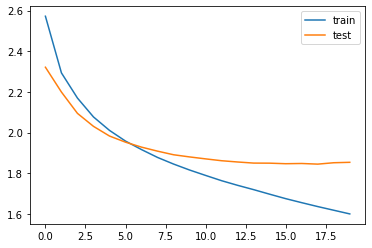

In [99]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [100]:
reverse_target_word_index= y_token.index_word
reverse_source_word_index= x_token.index_word
target_word_index= y_token.word_index

## Inference

In [101]:
encoder_model= Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h, state_c])

#here we have used the decoder state to store the previous time state 
decoder_state_input_h= Input(shape=(latent_dim,))
decoder_state_input_c= Input(shape=(latent_dim,))
decoder_hidden_state_input= Input(shape=(max_text_length,latent_dim))

#using the embedding layer to the decoder input 
dec_embd2= dec_em_ly(decoder_inputs)
decoder_output2, state_h2,state_c2= decoder_lstm(dec_embd2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#this is a dense softmax layer to generate a probability distribution over the target variable
decoder_output2= decoder_dense(decoder_output2)

#final decoder output model 
decoder_model= Model([decoder_inputs]+[decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
                     [decoder_output2]+ [state_h2,state_c2])



In [102]:
def sequence_dec(input_seq):
    e_out, e_h, e_c= encoder_model.predict(input_seq)
    target_sequence= np.zeros((1,1))
    target_sequence[0,0]= target_word_index['ssstok']

    stop_condition=False
    decode_sentences=''
    while not stop_condition:
        
        output_token, h, c=decoder_model.predict([target_sequence]+[e_out, e_h,e_c])

        sampled_token_index= np.argmax(output_token[0, -1, :])
        sampled_token= reverse_target_word_index[sampled_token_index]

        if (sampled_token!= 'eeetok'):
            decode_sentences += ' '+sampled_token

        if (sampled_token== 'eeetok' or len(decode_sentences.split())>= (max_summary_length-1)):
            stop_condition= True

            target_seguence=np.zeros((1,1))
            target_sequence[0,0]= sampled_token_index

            e_h, e_c= h,c

    return decode_sentences  

In [103]:
def seq2summary(input_seq):
    new_string=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['ssstok']) and i!=target_word_index['eeetok']):
            new_string=new_string+reverse_target_word_index[i]+' '
            
    return new_string

def seq2text(input_seq):
    new_string=''
    for i in input_seq:
        if(i!=0):
            new_string=new_string+reverse_source_word_index[i]+' '
            
    return new_string


In [104]:
for i in range(0,100):
    print('Review -:', seq2text(x_train[i]))
    print('Orignal Summary -:', seq2summary(y_train[i]))
    print('Predicted Summary -:', sequence_dec(x_train[i].reshape(1,max_text_length)))
    print("\n")

Review -: ordered pb plain chocolate peanut butter variety vastly pleased mixed according directions eaten crackers mixed raisins sunflower seeds favorite use however refrigerator porridge recipe enjoy 
Orignal Summary -: pb 
Predicted Summary -:  delicious


Review -: totally agree swiss miss suggestion maybe write swiss miss come cup 
Orignal Summary -: sucralose 
Predicted Summary -:  not good


Review -: cut tiny calorie servings bit silly brownies wonderful fat free heaven willing mail order nonfat treat try hot frozen cool whip top send diet taste 
Orignal Summary -: delicious and wonderful treat 
Predicted Summary -:  delicious


Review -: received order quickly much faster expected pepper loves cookies favorite pretty much anything get one nice sized fall apart cute shapes 
Orignal Summary -: pepper favorites 
Predicted Summary -:  great product


Review -: twinings come winner variety pack highly recommended flavors pack best best disappointed purchase comes tea twinings best 